In [1]:
from pyspark.sql import SparkSession
from classes.NewsGraph import NewsGraph

In [10]:
# NEO4J_URI= "neo4j+s://4590fd45.databases.neo4j.io"
# NEO4J_USERNAME= 'neo4j'
# NEO4J_PASSWORD= "e7HC7RfhsvpFjpRmHcLxgFD6FiI-gPkgqpBzNHyn9vA"
# AURA_INSTANCEID= "4590fd45"
# AURA_INSTANCENAME= "Instance01"

In [2]:
NEO4J_URI='neo4j+s://a0994a4a.databases.neo4j.io'
NEO4J_USERNAME='neo4j'
NEO4J_PASSWORD='wfemtxOHWYj9i0y3dln8TdauyfC7fE3Co19ZK4mhMDM'
AURA_INSTANCEID='a0994a4a'
AURA_INSTANCENAME='Free instance'

In [3]:
ng = NewsGraph( NEO4J_URI, NEO4J_USERNAME, NEO4J_PASSWORD)

In [4]:
ng.verify_connection()

✅ Connection successful!


In [5]:
spark = SparkSession.builder \
    .appName("Neo4j Query") \
    .getOrCreate()

25/04/17 09:34:31 WARN Utils: Your hostname, Macpad5Pro. resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/04/17 09:34:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/17 09:34:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/17 09:34:35 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/04/17 09:34:35 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


### Top Categories by Article Count

In [7]:
with open('stop_words.txt', 'r') as f:
    stop_words = f.read().splitlines()  # Read and split each line into a list

query = """
WITH $stop_words AS stopWords
MATCH (n:News)
WITH n, [word IN split(toLower(n.title), ' ') WHERE NOT word IN stopWords AND word <> ""] AS words
UNWIND words AS word
MATCH (n)-[:RELATED_TO]->(n2:News)
WHERE n <> n2
WITH word, n2.title AS relatedTitle
WITH word, COLLECT(DISTINCT relatedTitle) AS relatedArticles
RETURN word, SIZE(relatedArticles) AS relatedCount, relatedArticles
ORDER BY relatedCount DESC
LIMIT 10

"""

# Run the query with stop words as parameters
parameters = {'stop_words': stop_words}
df = ng.run_cypher_query(spark, query, parameters)
df.show()

+--------------------+------------+--------+
|     relatedArticles|relatedCount|    word|
+--------------------+------------+--------+
|[China backs Mala...|         196|   perak|
|[China backs Mala...|         189|   seven|
|[Family heading h...|         188|  public|
|[China backs Mala...|         183|    dept|
|[Sufficient suppl...|         181|    cops|
|[China backs Mala...|         180|  health|
|[Sufficient suppl...|         180|products|
|[Sufficient suppl...|         180|     gua|
|[Raya rush: Traff...|         179|   works|
|[China backs Mala...|         177|  repair|
+--------------------+------------+--------+



In [20]:
query = """
MATCH (n1:News)-[:RELATED_TO]->(n2:News)
MATCH (n1)-[:PUBLISHED_ON]->(t1:Time), (n2)-[:PUBLISHED_ON]->(t2:Time)
MATCH (n1)-[:HAS_CATEGORY]->(c1:Category), (n2)-[:HAS_CATEGORY]->(c2:Category)
MATCH (n1)-[:REPORTED_IN]->(l1:Location), (n2)-[:REPORTED_IN]->(l2:Location)
MATCH (n1)-[:BELONGS_TO]->(ss1:SubSection), (n2)-[:BELONGS_TO]->(ss2:SubSection)
WHERE n1 <> n2
RETURN 
    n1.title AS news1, 
    t1.date AS publish_date1, 
    c1.name AS category1, 
    l1.name AS location1, 
    ss1.name AS sub_section1,
    n2.title AS news2, 
    t2.date AS publish_date2, 
    c2.name AS category2, 
    l2.name AS location2, 
    ss2.name AS sub_section2
ORDER BY publish_date1 DESC

"""
df = ng.run_cypher_query(spark, query)
df.show()

+---------+---------+------------+------------------+--------------------+--------------------+--------------------+--------------------+------------+------------+
|category1|category2|   location1|         location2|               news1|               news2|       publish_date1|       publish_date2|sub_section1|sub_section2|
+---------+---------+------------+------------------+--------------------+--------------------+--------------------+--------------------+------------+------------+
| negative| positive|KUALA LUMPUR|           JAKARTA|Myanmar quake: SM...|China backs Malay...|{-1, 3, 739341, 2...|{21, 3, 739331, 2...|      Nation|      Nation|
| negative| positive|KUALA LUMPUR|         KOTA BARU|Myanmar quake: SM...|Sufficient supply...|{-1, 3, 739341, 2...|{13, 3, 739323, 2...|      Nation|      Nation|
| negative| positive|KUALA LUMPUR|      KUALA LUMPUR|Myanmar quake: SM...|Cops probing vide...|{-1, 3, 739341, 2...|{26, 3, 739336, 2...|      Nation|      Nation|
| negative| nega

In [6]:
query = """
MATCH (n:News)-[:PUBLISHED_ON]->(t:Time)
RETURN n.title AS news_title, n.summary AS news_summary, t.date AS publish_date
LIMIT 10
"""



df = ng.run_cypher_query(spark, query)
df.show()

+--------------------+--------------------+--------------------+
|        news_summary|          news_title|        publish_date|
+--------------------+--------------------+--------------------+
|jakarta china has...|China backs Malay...|{21, 3, 739331, 2...|
|kuala lumpur two ...|Two films blocked...|{21, 3, 739331, 2...|
|petaling jaya the...|Flood situation w...|{21, 3, 739331, 2...|
|kuala lumpur the ...|Malaysians report...|{21, 3, 739331, 2...|
|kota kinabalu sab...|Sabah Umno hits o...|{21, 3, 739331, 2...|
|kuala kangsar the...|Jakim lodges poli...|{21, 3, 739331, 2...|
|malaysia has been...|Malaysia ranked a...|{21, 3, 739331, 2...|
|kuala lumpur form...|Former Sabah mini...|{21, 3, 739331, 2...|
|chukai prime mini...|Anwar announces R...|{21, 3, 739331, 2...|
|london bloomberg ...|Heathrow shutdown...|{21, 3, 739331, 2...|
+--------------------+--------------------+--------------------+



In [7]:
import pandas as pd
pd.set_option('display.max_colwidth', None)  # This will allow full width in the columns
df.head(20)


[Row(news_summary='jakarta china has pledged strong support for malaysias asean  chairmanship emphasising the aseanchina free trade area acfta  protocol signing as a key priority for regional economic integration', news_title="China backs Malaysia's Asean leadership", publish_date=Row(_Date__day=21, _Date__month=3, _Date__ordinal=739331, _Date__year=2025)),
 Row(news_summary='kuala lumpur two films that received incentives from the creative content fund dkk have been blocked from screening due to producers failure to pay production crew wages says datuk fahmi fadzil', news_title='Two films blocked from screening for not paying production crew', publish_date=Row(_Date__day=21, _Date__month=3, _Date__ordinal=739331, _Date__year=2025)),
 Row(news_summary='petaling jaya the flood situation in sarawak has worsened with the number of evacuees rising steadily', news_title='Flood situation worsens in Sarawak, improves in Sabah as evacuee numbers shift', publish_date=Row(_Date__day=21, _Date__m

In [8]:
query = """
MATCH (n:News)
WITH n, split(toLower(n.title), ' ') AS words  // Keep the original node 'n' to count articles
UNWIND words AS word  // Unwind each word into individual rows
WITH word, COUNT(n) AS article_count  // Count how many articles contain each word
WHERE word IS NOT NULL 
  AND word <> "" 
  AND NOT word IN ['after','from','says','the', 'and', 'of', 'to', 'a', 'in', 'is', 'on', 'for', 'with', 'as', 'by', 'at', 'an', 'be', 'this', 'that']  // Exclude stop words
RETURN word, article_count
ORDER BY article_count DESC
LIMIT 10

"""
df = ng.run_cypher_query(spark, query)
df.show()

+-------------+--------+
|article_count|    word|
+-------------+--------+
|           16|    raya|
|           15|    hari|
|           14|    over|
|           10|   anwar|
|            8|     two|
|            8|      pm|
|            8| myanmar|
|            7|    into|
|            7|selangor|
|            7|  sultan|
+-------------+--------+



## Query 1

In [9]:
#This query helps identify the most frequent keywords in news article titles over time, excluding common stop words, and provides insights 
#into the distribution of these keywords by publication date, revealing trends and shifts in news coverage.

# Load stop words from a file
with open('stop_words.txt', 'r') as f:
    stop_words = f.read().splitlines()  # Read and split each line into a list

# Define the Cypher query with a placeholder for the stop words
query = """
MATCH (n:News)-[:PUBLISHED_ON]->(t:Time),
      (n)-[:BELONGS_TO]->(ss:SubSection)-[:PART_OF]->(s:Section),
      (n)-[:REPORTED_IN]->(l:Location),
      (n)-[:HAS_CATEGORY]->(c:Category)
RETURN n.title AS news_title, n.summary AS news_summary,toString(t.date) AS publish_date,
       ss.name AS subsection_name, s.name AS section_name, l.name AS location_name, c.name AS category_name

"""

# Pass the stop words as a parameter to the query
parameters = {'stop_words': stop_words}

# Run the query using the `ng` class
df = ng.run_cypher_query(spark, query, parameters)

# Show the results
df.show()


+-------------+-------------+--------------------+--------------------+------------+------------+---------------+
|category_name|location_name|        news_summary|          news_title|publish_date|section_name|subsection_name|
+-------------+-------------+--------------------+--------------------+------------+------------+---------------+
|     positive|      JAKARTA|jakarta china has...|China backs Malay...|  2025-03-21|        News|         Nation|
|     positive|    KOTA BARU|kota baru the agr...|Sufficient supply...|  2025-03-13|        News|         Nation|
|     positive| KUALA LUMPUR|kuala lumpur poli...|Cops probing vide...|  2025-03-26|        News|         Nation|
|     negative|KOTA KINABALU|kota kinabalu a f...|Family heading ho...|  2025-03-28|        News|         Nation|
|      neutral|KOTA KINABALU|kota kinabalu lab...|Woman claims male...|  2025-03-22|        News|         Nation|
|     positive| KUALA LUMPUR|kuala lumpur traf...|Raya rush: Traffi...|  2025-03-28|    

In [10]:
#This query helps identify the most frequent keywords in news article titles over time, excluding common stop words, and provides insights 
#into the distribution of these keywords by publication date, revealing trends and shifts in news coverage.

# Load stop words from a file
with open('stop_words.txt', 'r') as f:
    stop_words = f.read().splitlines()  # Read and split each line into a list

# Define the Cypher query with a placeholder for the stop words
query = """
MATCH (n:News)-[:PUBLISHED_ON]->(t:Time)
WITH n, 
     split(toLower(n.title), ' ') AS words, 
     toString(t.date) AS Publish_date  // Convert the 'date' property of Time node to String
UNWIND words AS word
WITH word, Publish_date, COUNT(n) AS article_count
WHERE word IS NOT NULL 
  AND word <> "" 
  AND NOT word IN $stop_words  // Pass stop_words as a parameter
RETURN word, Publish_date, SUM(article_count) AS total_articles
ORDER BY Publish_date DESC, total_articles DESC
LIMIT 10
"""

# Pass the stop words as a parameter to the query
parameters = {'stop_words': stop_words}

# Run the query using the `ng` class
df = ng.run_cypher_query(spark, query, parameters)

# Show the results
df.show()


+------------+--------------+--------+
|Publish_date|total_articles|    word|
+------------+--------------+--------+
|  2025-03-31|             3|    hari|
|  2025-03-31|             3|    raya|
|  2025-03-31|             2|     boy|
|  2025-03-31|             2|    open|
|  2025-03-31|             1|rescuing|
|  2025-03-31|             1| focuses|
|  2025-03-31|             1|  places|
|  2025-03-31|             1|  quake:|
|  2025-03-31|             1| victims|
|  2025-03-31|             1| myanmar|
+------------+--------------+--------+



In [11]:
#This query helps identify the most frequent keywords in news article titles over time, excluding common stop words, and provides insights 
#into the distribution of these keywords by publication date, revealing trends and shifts in news coverage.

# Load stop words from a file
with open('stop_words.txt', 'r') as f:
    stop_words = f.read().splitlines()  # Read and split each line into a list

# Define the Cypher query with a placeholder for the stop words
query = """
MATCH (n:News)
WITH n, 
     split(toLower(n.title), ' ') AS words, 
     toString(date(n.publish_time).year) + "-" + 
     toString(date(n.publish_time).month) + "-" + 
     toString(date(n.publish_time).day) AS Publish_date
UNWIND words AS word
WITH word, Publish_date, COUNT(n) AS article_count
WHERE word IS NOT NULL 
  AND word <> "" 
  AND NOT word IN $stop_words  // Pass stop_words as a parameter
RETURN word, Publish_date, SUM(article_count) AS total_articles
ORDER BY Publish_date DESC, total_articles DESC
LIMIT 10
"""

# Pass the stop words as a parameter to the query
parameters = {'stop_words': stop_words}

# Run the query using the `ng` class
df = ng.run_cypher_query(spark, query, parameters)

# Show the results
df.show()


+------------+--------------+--------+
|Publish_date|total_articles|    word|
+------------+--------------+--------+
|   2025-3-31|             3|    hari|
|   2025-3-31|             3|    raya|
|   2025-3-31|             2|     boy|
|   2025-3-31|             2|    open|
|   2025-3-31|             1|  places|
|   2025-3-31|             1| victims|
|   2025-3-31|             1| worship|
|   2025-3-31|             1| focuses|
|   2025-3-31|             1|rescuing|
|   2025-3-31|             1|  quake:|
+------------+--------------+--------+



## Query 2

In [12]:
# Load stop words
with open('stop_words.txt', 'r') as f:
    stop_words = f.read().splitlines()

# Updated Cypher query
query = """
MATCH (n:News)-[:HAS_CATEGORY]->(c:Category)
MATCH (n)-[:PUBLISHED_ON]->(t:Time)
WITH n, 
     split(toLower(n.title), ' ') AS words, 
     toString(t.date) AS formatted_publish_date, 
     c.name AS sentiment  
UNWIND words AS word
WITH word, formatted_publish_date, sentiment, COUNT(n) AS article_count
WHERE word IS NOT NULL 
  AND word <> "" 
  AND NOT word IN $stop_words
WITH word, formatted_publish_date, 
     SUM(CASE WHEN sentiment = 'positive' THEN article_count ELSE 0 END) AS positive_count,
     SUM(CASE WHEN sentiment = 'neutral' THEN article_count ELSE 0 END) AS neutral_count,
     SUM(CASE WHEN sentiment = 'negative' THEN article_count ELSE 0 END) AS negative_count,
     (SUM(CASE WHEN sentiment = 'positive' THEN article_count ELSE 0 END) + 
      SUM(CASE WHEN sentiment = 'neutral' THEN article_count ELSE 0 END) + 
      SUM(CASE WHEN sentiment = 'negative' THEN article_count ELSE 0 END)) AS total_count
RETURN word, formatted_publish_date, positive_count, neutral_count, negative_count, total_count
ORDER BY total_count DESC, word ASC
LIMIT 10
"""

# Run with parameters
parameters = {'stop_words': stop_words}
df = ng.run_cypher_query(spark, query, parameters)
df.show()


+----------------------+--------------+-------------+--------------+-----------+-------+
|formatted_publish_date|negative_count|neutral_count|positive_count|total_count|   word|
+----------------------+--------------+-------------+--------------+-----------+-------+
|            2025-03-29|             0|            0|             4|          4|   hari|
|            2025-03-28|             0|            0|             4|          4|myanmar|
|            2025-03-29|             0|            0|             4|          4|   raya|
|            2025-03-15|             3|            0|             0|          3|  after|
|            2025-03-29|             0|            0|             3|          3|exodus:|
|            2025-03-30|             0|            0|             3|          3|   hari|
|            2025-03-31|             0|            1|             2|          3|   hari|
|            2025-03-27|             0|            2|             1|          3| police|
|            2025-03-

## Query 3

In [13]:
#This query will give you a good overview of how the sentiment distribution varies across different times of the day.

query = """
MATCH (n:News)-[:HAS_CATEGORY]->(c:Category)
MATCH (n)-[:PUBLISHED_ON]->(t:Time)
WITH n,
     toString(t.date) AS formatted_publish_date,
     time(n.publish_time).hour AS hour,
     c.name AS sentiment
WITH formatted_publish_date, 
     CASE
         WHEN hour >= 6 AND hour < 12 THEN 'Morning'
         WHEN hour >= 12 AND hour < 18 THEN 'Afternoon'
         ELSE 'Night'
     END AS time_period,
     sentiment,
     COUNT(n) AS article_count
WITH time_period, sentiment, SUM(article_count) AS total_articles
ORDER BY time_period, total_articles DESC
RETURN time_period, sentiment, total_articles
"""


df = ng.run_cypher_query(spark, query)
df.show()


+---------+-----------+--------------+
|sentiment|time_period|total_articles|
+---------+-----------+--------------+
| positive|  Afternoon|             2|
| negative|  Afternoon|             1|
|  neutral|  Afternoon|             1|
| positive|      Night|            88|
| negative|      Night|            69|
|  neutral|      Night|            39|
+---------+-----------+--------------+



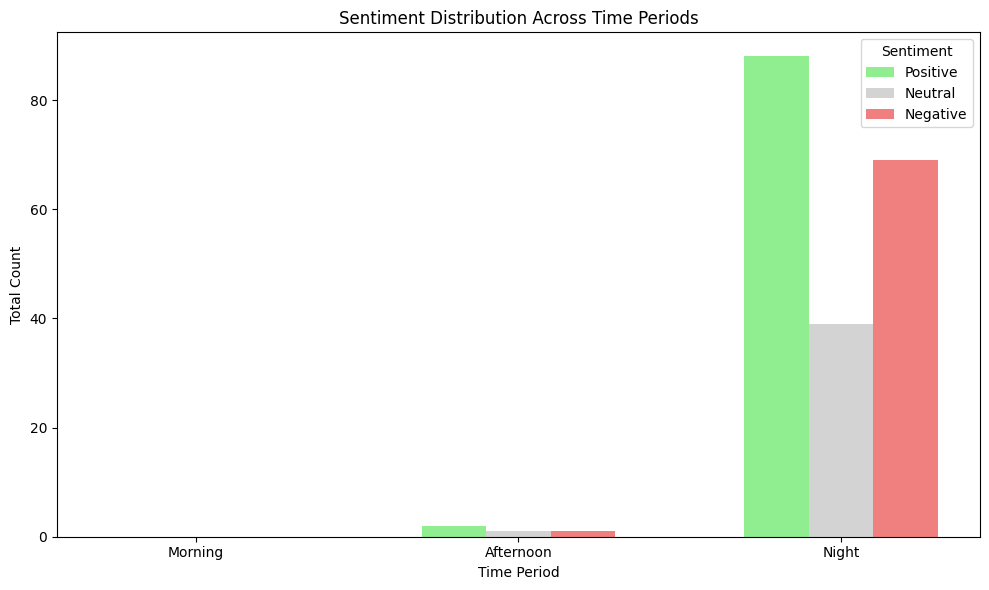

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define the updated query using :PUBLISHED_ON and keeping hour from n.publish_time
query = """
MATCH (n:News)-[:HAS_CATEGORY]->(c:Category)
MATCH (n)-[:PUBLISHED_ON]->(t:Time)
WITH n,
     toString(t.date) AS formatted_publish_date,
     time(n.publish_time).hour AS hour,
     c.name AS sentiment
WITH formatted_publish_date, 
     CASE
         WHEN hour >= 6 AND hour < 12 THEN 'Morning'
         WHEN hour >= 12 AND hour < 18 THEN 'Afternoon'
         ELSE 'Night'
     END AS time_period,
     sentiment,
     COUNT(n) AS article_count
WITH time_period, sentiment, SUM(article_count) AS total_count
ORDER BY time_period, sentiment
RETURN time_period, sentiment, total_count
"""

# Run the query using the ng class
df = ng.run_cypher_query(spark, query)

# Collect results
results = df.collect()

# Extract and group data
time_periods = [row['time_period'] for row in results]
sentiments = [row['sentiment'] for row in results]
total_counts = [row['total_count'] for row in results]

# Organize counts per sentiment
time_periods_unique = ['Morning', 'Afternoon', 'Night']
positive_counts = [sum([total_counts[i] for i in range(len(time_periods)) if time_periods[i] == period and sentiments[i] == 'positive']) for period in time_periods_unique]
neutral_counts  = [sum([total_counts[i] for i in range(len(time_periods)) if time_periods[i] == period and sentiments[i] == 'neutral']) for period in time_periods_unique]
negative_counts = [sum([total_counts[i] for i in range(len(time_periods)) if time_periods[i] == period and sentiments[i] == 'negative']) for period in time_periods_unique]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
index = range(len(time_periods_unique))

ax.bar(index, positive_counts, bar_width, label='Positive', color='lightgreen')
ax.bar([i + bar_width for i in index], neutral_counts, bar_width, label='Neutral', color='lightgray')
ax.bar([i + 2 * bar_width for i in index], negative_counts, bar_width, label='Negative', color='lightcoral')

# Labels & titles
ax.set_xlabel('Time Period')
ax.set_ylabel('Total Count')
ax.set_title('Sentiment Distribution Across Time Periods')
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(time_periods_unique)
ax.legend(title="Sentiment")

plt.tight_layout()
plt.show()


## Query 4

In [15]:
#This type of query is very useful for understanding the evolution
#of article sentiment and its relation to different Sections and SubSections over time.

query = """
MATCH (n:News)-[:BELONGS_TO]->(ss:SubSection)-[:PART_OF]->(s:Section),
      (n)-[:HAS_CATEGORY]->(c:Category),
      (n)-[:PUBLISHED_ON]->(t:Time)
WITH s.name AS Section, 
     ss.name AS SubSection, 
     c.name AS Category, 
     toString(date(t.date).year) + "-" + toString(date(t.date).month) AS publish_month, 
     COUNT(n) AS total_articles
WITH Section, SubSection, publish_month, 
     SUM(CASE WHEN Category = 'positive' THEN total_articles ELSE 0 END) AS positive_count,
     SUM(CASE WHEN Category = 'neutral' THEN total_articles ELSE 0 END) AS neutral_count,
     SUM(CASE WHEN Category = 'negative' THEN total_articles ELSE 0 END) AS negative_count,
     (SUM(CASE WHEN Category = 'positive' THEN total_articles ELSE 0 END) +
      SUM(CASE WHEN Category = 'neutral' THEN total_articles ELSE 0 END) +
      SUM(CASE WHEN Category = 'negative' THEN total_articles ELSE 0 END)) AS total_count
RETURN Section, SubSection, publish_month, positive_count, neutral_count, negative_count, total_count
ORDER BY total_count DESC
LIMIT 10

"""
df = ng.run_cypher_query(spark, query)
df.show()

+---------+--------------+--------------+-------------+--------------+-------------+-----------+
|  Section|    SubSection|negative_count|neutral_count|positive_count|publish_month|total_count|
+---------+--------------+--------------+-------------+--------------+-------------+-----------+
|     News|        Nation|            67|           39|            84|       2025-3|        190|
|AseanPlus|Aseanplus News|             1|            1|             5|       2025-3|          7|
|     News|         World|             2|            0|             0|       2025-3|          2|
| Business| Business News|             0|            0|             1|       2025-3|          1|
+---------+--------------+--------------+-------------+--------------+-------------+-----------+



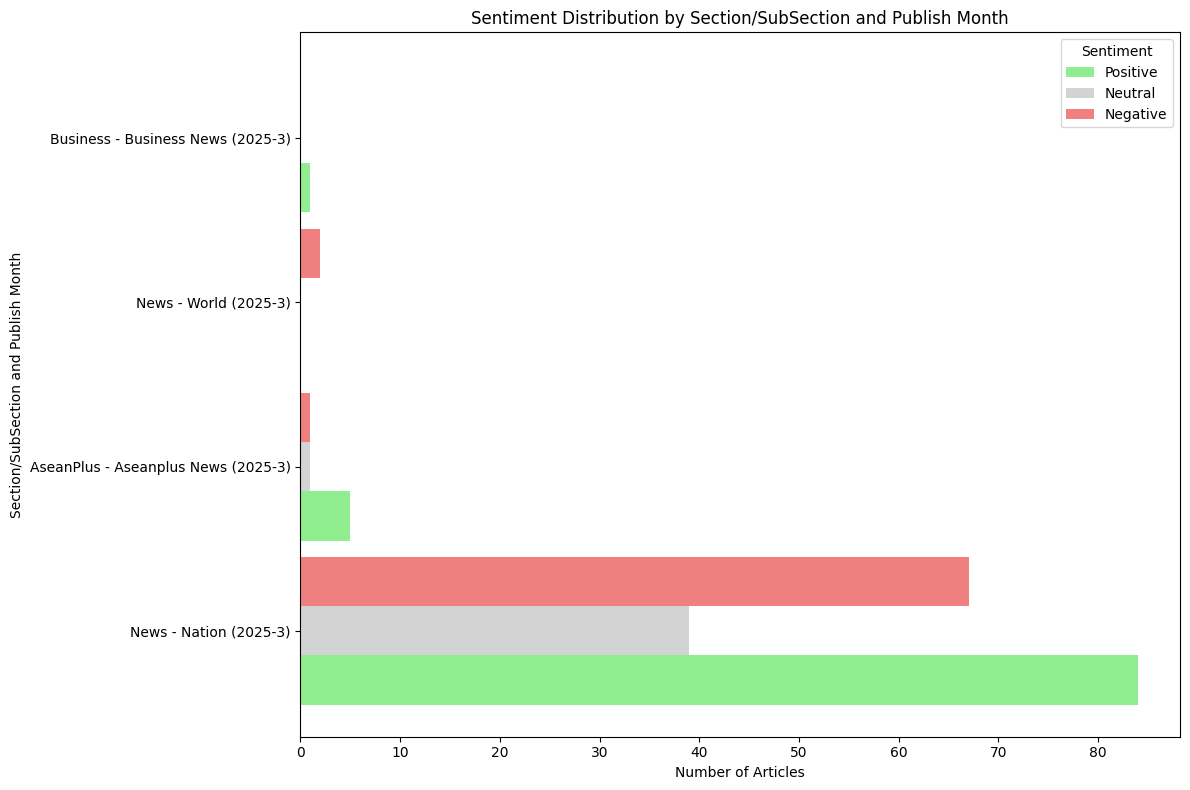

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define the query
query = """
MATCH (n:News)-[:BELONGS_TO]->(ss:SubSection)-[:PART_OF]->(s:Section),
      (n)-[:HAS_CATEGORY]->(c:Category),
      (n)-[:PUBLISHED_ON]->(t:Time)
WITH s.name AS Section, 
     ss.name AS SubSection, 
     c.name AS Category, 
     toString(date(t.date).year) + "-" + toString(date(t.date).month) AS publish_month, 
     COUNT(n) AS total_articles
WITH Section, SubSection, publish_month, 
     SUM(CASE WHEN Category = 'positive' THEN total_articles ELSE 0 END) AS positive_count,
     SUM(CASE WHEN Category = 'neutral' THEN total_articles ELSE 0 END) AS neutral_count,
     SUM(CASE WHEN Category = 'negative' THEN total_articles ELSE 0 END) AS negative_count,
     (SUM(CASE WHEN Category = 'positive' THEN total_articles ELSE 0 END) +
      SUM(CASE WHEN Category = 'neutral' THEN total_articles ELSE 0 END) +
      SUM(CASE WHEN Category = 'negative' THEN total_articles ELSE 0 END)) AS total_count
RETURN Section, SubSection, publish_month, positive_count, neutral_count, negative_count, total_count
ORDER BY total_count DESC
LIMIT 10
"""

# Run the query with the appropriate parameters
df = ng.run_cypher_query(spark, query)

# Collecting the results for visualization
data = df.collect()

# Extracting relevant data for plotting
sections = [row['Section'] for row in data]
subsections = [row['SubSection'] for row in data]
publish_months = [row['publish_month'] for row in data]
positive_counts = [row['positive_count'] for row in data]
neutral_counts = [row['neutral_count'] for row in data]
negative_counts = [row['negative_count'] for row in data]
total_counts = [row['total_count'] for row in data]

# Prepare data for plotting
labels = [f"{section} - {subsection} ({month})" for section, subsection, month in zip(sections, subsections, publish_months)]

# Plotting the data
plt.figure(figsize=(12, 8))  # Set the figure size
bar_width = 0.3  # Width of the bars for grouping
index = range(len(labels))

# Plotting each sentiment category with different colors
plt.barh(index, positive_counts, color='lightgreen', label='Positive', height=bar_width)
plt.barh([i + bar_width for i in index], neutral_counts, color='lightgray', label='Neutral', height=bar_width)
plt.barh([i + 2 * bar_width for i in index], negative_counts, color='lightcoral', label='Negative', height=bar_width)

# Adding labels and title
plt.xlabel('Number of Articles')
plt.ylabel('Section/SubSection and Publish Month')
plt.title('Sentiment Distribution by Section/SubSection and Publish Month')
plt.yticks([i + bar_width for i in index], labels)  # Adjust the y-ticks to match the labels
plt.tight_layout()

# Add a legend to explain the color coding
plt.legend(title="Sentiment", loc="upper right")

# Show the plot
plt.show()


## Query 5

In [17]:
# This output will show you the most frequent keywords (from the titles) by location and sentiment (positive, neutral, and negative).

# Load stop words from the stop_words.txt file
with open('stop_words.txt', 'r') as f:
    stop_words = f.read().splitlines()  # Read and split each line into a list

# Define the Cypher query with a placeholder for the stop words
query = """
MATCH (n:News)-[:REPORTED_IN]->(l:Location),
      (n)-[:HAS_CATEGORY]->(c:Category)
WITH l.name AS location, 
     c.name AS sentiment, 
     split(toLower(n.title), ' ') AS words,
     COUNT(n) AS article_count
UNWIND words AS word
WITH location, sentiment, word, article_count
WHERE word IS NOT NULL 
  AND word <> "" 
  AND NOT word IN $stop_words  // Exclude stop words dynamically
WITH location, sentiment, word, SUM(article_count) AS total_count
ORDER BY total_count DESC
RETURN location, sentiment, word, total_count
LIMIT 20
"""

# Pass the stop words as a parameter to the query
parameters = {'stop_words': stop_words}

# Run the query using the `ng` class
df = ng.run_cypher_query(spark, query, parameters)
df.show()


+------------------+---------+-----------+----------+
|          location|sentiment|total_count|      word|
+------------------+---------+-----------+----------+
|      KUALA LUMPUR| positive|          5|      raya|
|      KUALA LUMPUR| positive|          4|     urges|
|Location not found| positive|          3|  malaysia|
|     PETALING JAYA| positive|          3|      hari|
|      KUALA LUMPUR| positive|          3|       pkr|
|      KUALA LUMPUR| positive|          3|     fahmi|
|              IPOH|  neutral|          3|     perak|
|     PETALING JAYA| positive|          3|   myanmar|
|      KUALA LUMPUR| positive|          3|   harmony|
|     PETALING JAYA| positive|          2|        pm|
|      KUALA LUMPUR| positive|          2|   myanmar|
|      KUALA LUMPUR| positive|          2|     force|
|     PETALING JAYA| positive|          2|     anwar|
|      KUALA LUMPUR| positive|          2|      post|
|      KUALA LUMPUR| positive|          2|malaysians|
|Location not found| positiv

## Query 6

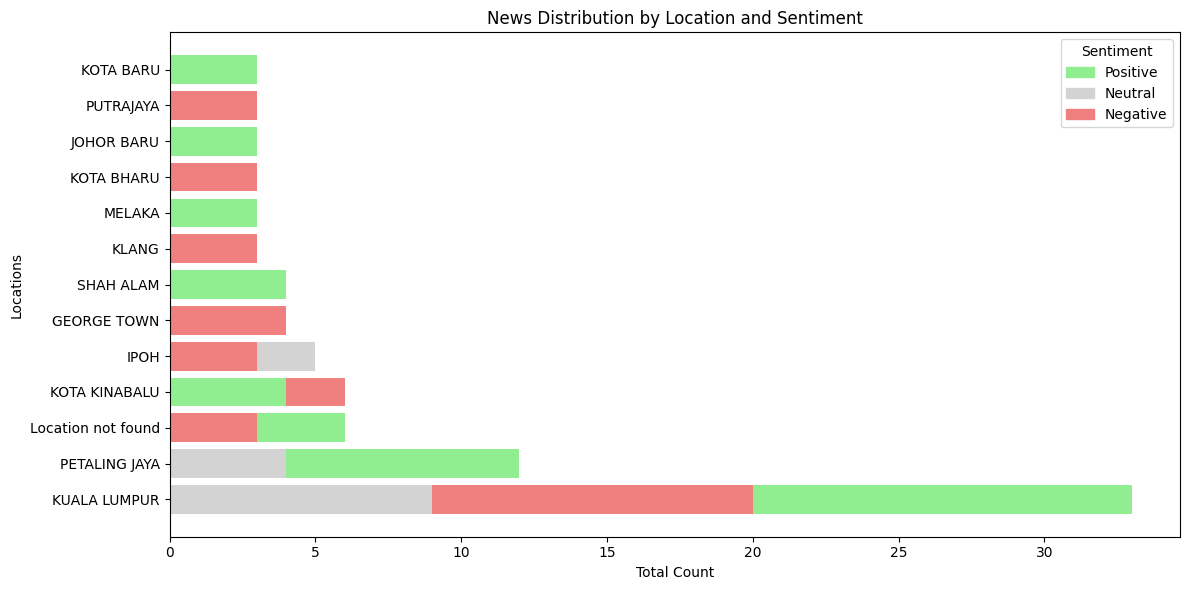

In [18]:
##This allows you to quickly see how news distribution varies by 
#location and sentiment. The plot also includes a legend to easily distinguish between the sentiments.

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define the query
query = """
MATCH (n:News)-[:REPORTED_IN]->(l:Location),
      (n)-[:HAS_CATEGORY]->(c:Category)
WITH l.name AS location, 
     c.name AS sentiment, 
     COUNT(n) AS article_count
WITH location, sentiment, SUM(article_count) AS total_count
ORDER BY total_count DESC
RETURN location, sentiment, total_count
LIMIT 20
"""

# Load stop words from a file (adjust the file path if necessary)
with open('stop_words.txt', 'r') as file:
    stop_words = [line.strip() for line in file.readlines()]

# Run the query with the stop words parameter
parameters = {'stop_words': stop_words}
df = ng.run_cypher_query(spark, query, parameters)

# Collect results from the PySpark DataFrame to the driver node
locations = df.collect()

# Extract location names, sentiment, and their corresponding counts
location_names = [row['location'] for row in locations]
sentiments = [row['sentiment'] for row in locations]
total_counts = [row['total_count'] for row in locations]

# Prepare data for plotting
# Assign colors based on sentiment
colors = []
for sentiment in sentiments:
    if sentiment == 'positive':
        colors.append('lightgreen')  # Color for positive sentiment
    elif sentiment == 'neutral':
        colors.append('lightgray')   # Color for neutral sentiment
    else:
        colors.append('lightcoral')  # Color for negative sentiment

# Plotting the data
plt.figure(figsize=(12, 6))  # Set the figure size (optional)
bars = plt.barh(location_names, total_counts, color=colors)  # Horizontal bar chart for better readability

# Add the title and labels
plt.title('News Distribution by Location and Sentiment')
plt.xlabel('Total Count')
plt.ylabel('Locations')

# Create a legend with the colors representing sentiment categories
legend_labels = {
    'Positive': 'lightgreen',
    'Neutral': 'lightgray',
    'Negative': 'lightcoral'
}

# Create patches for each sentiment and add them to the legend
handles = [mpatches.Patch(color=color, label=label) for label, color in legend_labels.items()]
plt.legend(handles=handles, title="Sentiment")

# Adjust the layout to ensure everything fits
plt.tight_layout()
plt.show()


## Query 7

Enter the keyword to search:  communist


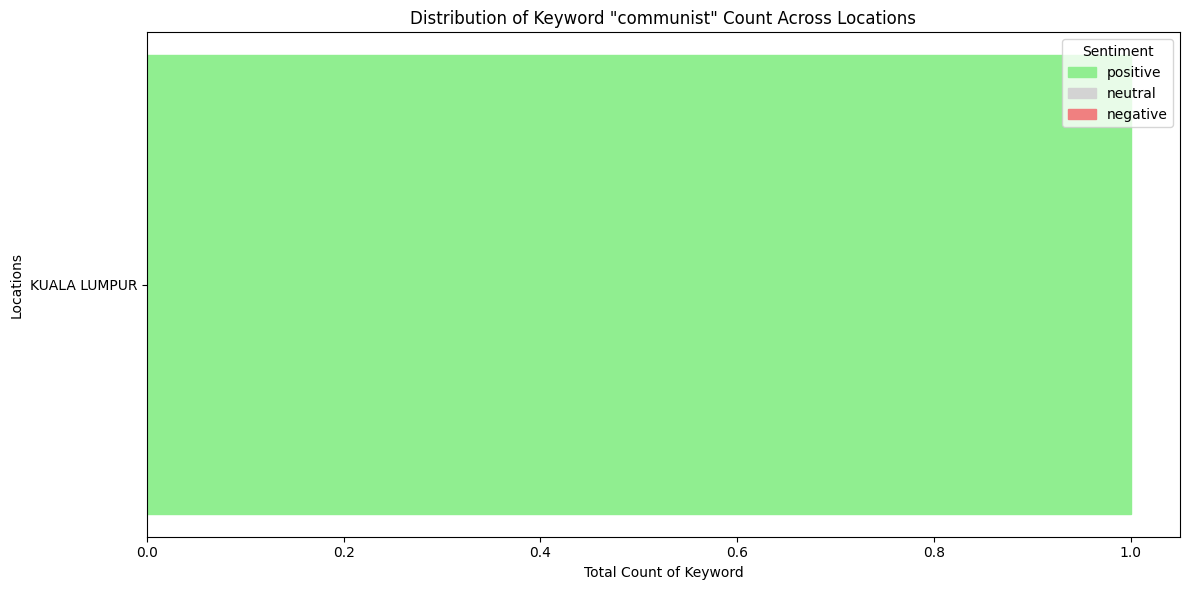

In [32]:
#This functionality allows business analysts to search for specific keywords in news articles and visualize their distribution across different locations,
#with sentiment breakdowns, to gain insights into how the keyword is perceived in various regions over time.

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Function to run the query and get the data
def search_and_visualize_keyword(keyword):
    # Define the Cypher query with the keyword placeholder
    query = """
    MATCH (n:News)-[:REPORTED_IN]->(l:Location),
          (n)-[:HAS_CATEGORY]->(c:Category)
    WITH l.name AS location, 
         c.name AS sentiment, 
         split(toLower(n.title), ' ') AS words,
         COUNT(n) AS article_count
    UNWIND words AS word
    WITH location, sentiment, word, article_count
    WHERE word IS NOT NULL 
      AND word <> "" 
      AND NOT word IN $stop_words
      AND word CONTAINS $keyword  // Search for the keyword
    WITH location, sentiment, word, SUM(article_count) AS total_count
    ORDER BY total_count DESC
    RETURN location, sentiment, word, total_count
    LIMIT 20
    """

    # Prompt for the stop words (you can replace this with a file if needed)
    with open('stop_words.txt', 'r') as file:
        stop_words = file.read().splitlines()

    # Set parameters for the query
    parameters = {'keyword': keyword, 'stop_words': stop_words}

    # Run the query using the ng class
    df = ng.run_cypher_query(spark, query, parameters)

    # Collect results from the PySpark DataFrame to the driver node
    locations = df.collect()

    # Extract the results
    location_names = [row['location'] for row in locations]
    words = [row['word'] for row in locations]
    sentiments = [row['sentiment'] for row in locations]
    total_counts = [row['total_count'] for row in locations]

    # Visualize the results
    plt.figure(figsize=(12, 6))

    # Plotting the data as a horizontal bar chart
    bars = plt.barh(location_names, total_counts, color='lightblue', edgecolor='black')

    # Adding labels and title
    plt.xlabel('Total Count of Keyword')
    plt.ylabel('Locations')
    plt.title(f'Distribution of Keyword "{keyword}" Count Across Locations')

    # Create a legend for sentiment
    sentiment_colors = {'positive': 'lightgreen', 'neutral': 'lightgray', 'negative': 'lightcoral'}
    handles = [mpatches.Patch(color=color, label=label) for label, color in sentiment_colors.items()]
    plt.legend(handles=handles, title="Sentiment")

    # Assign colors based on sentiment
    for i, bar in enumerate(bars):
        sentiment = sentiments[i]
        if sentiment == 'positive':
            bar.set_color('lightgreen')
        elif sentiment == 'neutral':
            bar.set_color('lightgray')
        else:
            bar.set_color('lightcoral')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage
keyword = input("Enter the keyword to search: ")
search_and_visualize_keyword(keyword)


## ----------------------------------------------------------------------------------------------------------------------

In [33]:
query = """
MATCH (n1:News)-[:REPORTED_IN]->(l:Location)<-[:REPORTED_IN]-(n2:News),
      (n1)-[:PUBLISHED_ON]->(t:Time)<-[:PUBLISHED_ON]-(n2)
WHERE id(n1) < id(n2)
RETURN n1.title AS News1, 
       n2.title AS News2, 
       l.name AS location, 
       date(t.date).year AS publish_year,
       date(t.date).month AS publish_month,
       date(t.date).day AS publish_day

"""
df = ng.run_cypher_query(spark, query)
df.show()

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated function: `id`.} {position: line: 4, column: 7, offset: 138} for query: '\nMATCH (n1:News)-[:REPORTED_IN]->(l:Location)<-[:REPORTED_IN]-(n2:News),\n      (n1)-[:PUBLISHED_ON]->(t:Time)<-[:PUBLISHED_ON]-(n2)\nWHERE id(n1) < id(n2)\nRETURN n1.title AS News1, \n       n2.title AS News2, \n       l.name AS location, \n       date(t.date).year AS publish_year,\n       date(t.date).month AS publish_month,\n       date(t.date).day AS publish_day\n\n'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated function: `id`

+--------------------+--------------------+------------------+-----------+-------------+------------+
|               News1|               News2|          location|publish_day|publish_month|publish_year|
+--------------------+--------------------+------------------+-----------+-------------+------------+
|Two films blocked...|Malaysians report...|      KUALA LUMPUR|         21|            3|        2025|
|Two films blocked...|Former Sabah mini...|      KUALA LUMPUR|         21|            3|        2025|
|Malaysians report...|Former Sabah mini...|      KUALA LUMPUR|         21|            3|        2025|
|Malaysia ranked a...|Heathrow shutdown...|Location not found|         21|            3|        2025|
|Over 70,000 cattl...|Kelantan gov't to...|        KOTA BHARU|         13|            3|        2025|
|Community service...|Al-Sultan Abdulla...| CAMERON HIGHLANDS|         13|            3|        2025|
|Cops probing vide...|Nanta wants swift...|      KUALA LUMPUR|         26|        

In [34]:
query = """
MATCH (n1:News)-[:REPORTED_IN]->(l:Location)<-[:REPORTED_IN]-(n2:News),
      (n1)-[:PUBLISHED_ON]->(t:Time)<-[:PUBLISHED_ON]-(n2)
WHERE id(n1) < id(n2)
RETURN n1.title AS News1, 
       n2.title AS News2, 
       l.name AS location, 
       date(t.date).year AS publish_year,
       date(t.date).month AS publish_month,
       date(t.date).day AS publish_day,
       datetime(t.date + "T00:00:00").hour AS publish_hour
"""
df = ng.run_cypher_query(spark, query)
df.show()


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated function: `id`.} {position: line: 4, column: 7, offset: 138} for query: '\nMATCH (n1:News)-[:REPORTED_IN]->(l:Location)<-[:REPORTED_IN]-(n2:News),\n      (n1)-[:PUBLISHED_ON]->(t:Time)<-[:PUBLISHED_ON]-(n2)\nWHERE id(n1) < id(n2)\nRETURN n1.title AS News1, \n       n2.title AS News2, \n       l.name AS location, \n       date(t.date).year AS publish_year,\n       date(t.date).month AS publish_month,\n       date(t.date).day AS publish_day,\n       datetime(t.date + "T00:00:00").hour AS publish_hour\n'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions

+--------------------+--------------------+------------------+-----------+------------+-------------+------------+
|               News1|               News2|          location|publish_day|publish_hour|publish_month|publish_year|
+--------------------+--------------------+------------------+-----------+------------+-------------+------------+
|Two films blocked...|Malaysians report...|      KUALA LUMPUR|         21|           0|            3|        2025|
|Two films blocked...|Former Sabah mini...|      KUALA LUMPUR|         21|           0|            3|        2025|
|Malaysians report...|Former Sabah mini...|      KUALA LUMPUR|         21|           0|            3|        2025|
|Malaysia ranked a...|Heathrow shutdown...|Location not found|         21|           0|            3|        2025|
|Over 70,000 cattl...|Kelantan gov't to...|        KOTA BHARU|         13|           0|            3|        2025|
|Community service...|Al-Sultan Abdulla...| CAMERON HIGHLANDS|         13|      

In [35]:
query = """
MATCH (n:News)-[:REPORTED_IN]->(l:Location)
RETURN l.name AS location, COUNT(n) AS news_count ORDER BY news_count DESC
"""

df = ng.run_cypher_query(spark, query)
df.show()

+------------------+----------+
|          location|news_count|
+------------------+----------+
|      KUALA LUMPUR|        62|
|     PETALING JAYA|        18|
|     KOTA KINABALU|        12|
|Location not found|        10|
|        JOHOR BARU|         8|
|              IPOH|         8|
|         SHAH ALAM|         7|
|            MELAKA|         6|
|         PUTRAJAYA|         5|
|        KOTA BHARU|         4|
|             KLANG|         4|
|       GEORGE TOWN|         4|
|  KUALA TERENGGANU|         4|
|         KOTA BARU|         3|
|          SEREMBAN|         3|
|            TAMPIN|         2|
|            SEPANG|         2|
|           KUANTAN|         2|
|        ALOR GAJAH|         2|
|              SIBU|         2|
+------------------+----------+
only showing top 20 rows



In [36]:
query = """
MATCH (n:News)-[:BELONGS_TO]->(ss:SubSection)
RETURN ss.name AS SubSection, COUNT(n) AS ArticleCount
ORDER BY ArticleCount DESC
"""

df = ng.run_cypher_query(spark, query)
df.show()

+------------+--------------+
|ArticleCount|    SubSection|
+------------+--------------+
|         190|        Nation|
|           7|Aseanplus News|
|           2|         World|
|           1| Business News|
+------------+--------------+



In [37]:
#Co-occurrence of Section, SubSection, and Category
query = """
MATCH (n:News)-[:BELONGS_TO]->(ss:SubSection)-[:PART_OF]->(s:Section)
MATCH (n)-[:HAS_CATEGORY]->(c:Category)
WITH s.name AS Section, ss.name AS SubSection, c.name AS Category, COUNT(n) AS Count
WHERE Count > 5  // Filter to show only strong co-occurrences
RETURN Section, SubSection, Category, Count
ORDER BY Count DESC
"""
df = ng.run_cypher_query(spark, query)
df.show()

+--------+-----+-------+----------+
|Category|Count|Section|SubSection|
+--------+-----+-------+----------+
|positive|   84|   News|    Nation|
|negative|   67|   News|    Nation|
| neutral|   39|   News|    Nation|
+--------+-----+-------+----------+



In [38]:
#Co-occurrence of Section, SubSection, and Category
query = """
MATCH (n:News)-[:BELONGS_TO]->(ss:SubSection)-[:PART_OF]->(s:Section)
MATCH (n)-[:HAS_CATEGORY]->(c:Category)
WITH s.name AS Section, ss.name AS SubSection, c.name AS Category, COUNT(n) AS Count
WHERE Count > 5  // Filter to show only strong co-occurrences
RETURN Section, SubSection, Category, Count
ORDER BY Count DESC
"""
df = ng.run_cypher_query(spark, query)
df.show()

#This part of the query finds how often certain sections, subsections, and categories co-occur.
#The WHERE Count > 5 filter ensures that only significant co-occurrences are returned.
#This can reveal patterns in how different types of content (e.g., "Politics" section and "Election" category) often appear together.

+--------+-----+-------+----------+
|Category|Count|Section|SubSection|
+--------+-----+-------+----------+
|positive|   84|   News|    Nation|
|negative|   67|   News|    Nation|
| neutral|   39|   News|    Nation|
+--------+-----+-------+----------+



In [39]:
#Clustering Articles Based on Section, SubSection, and Category
query = """
MATCH (n:News)-[:BELONGS_TO]->(ss:SubSection)-[:PART_OF]->(s:Section)
MATCH (n)-[:HAS_CATEGORY]->(c:Category)
WITH s.name AS Section, ss.name AS SubSection, c.name AS Category, COUNT(n) AS NumberOfArticles
ORDER BY NumberOfArticles DESC
WITH Section, SubSection, Category, NumberOfArticles
WHERE NumberOfArticles > 2
RETURN Section, SubSection, Category, NumberOfArticles
ORDER BY NumberOfArticles DESC
"""
df = ng.run_cypher_query(spark, query)
df.show()

#Clustering Articles Based on Section, SubSection, and Category:
#This query performs clustering based on multiple properties (section, subsection, and category), helping to identify articles that share similar characteristics.
#It looks for strong clusters that might indicate patterns in how content is grouped.

+--------+----------------+---------+--------------+
|Category|NumberOfArticles|  Section|    SubSection|
+--------+----------------+---------+--------------+
|positive|              84|     News|        Nation|
|negative|              67|     News|        Nation|
| neutral|              39|     News|        Nation|
|positive|               5|AseanPlus|Aseanplus News|
+--------+----------------+---------+--------------+



In [40]:
#Query to Find the Most Reported Locations and Their Corresponding Categories
query = """
MATCH (n:News)-[:REPORTED_IN]->(l:Location),
      (n)-[:HAS_CATEGORY]->(c:Category)
RETURN l.name AS Location,
       c.name AS Category,
       COUNT(n) AS ArticleCount
ORDER BY ArticleCount DESC
LIMIT 10
"""
df = ng.run_cypher_query(spark, query)
df.show()
#This query shows the most reported locations along with their associated categories, providing an overview of what topics are being discussed where.


+------------+--------+------------------+
|ArticleCount|Category|          Location|
+------------+--------+------------------+
|          33|positive|      KUALA LUMPUR|
|          20|negative|      KUALA LUMPUR|
|          12|positive|     PETALING JAYA|
|           9| neutral|      KUALA LUMPUR|
|           6|positive|Location not found|
|           6|negative|     KOTA KINABALU|
|           5| neutral|              IPOH|
|           4|negative|       GEORGE TOWN|
|           4|positive|     KOTA KINABALU|
|           4|positive|         SHAH ALAM|
+------------+--------+------------------+



In [41]:
#Categories and Their Impact in Each Section and Subsection
query = """
MATCH (n:News)-[:HAS_CATEGORY]->(c:Category), (n)-[:BELONGS_TO]->(ss:SubSection)-[:PART_OF]->(s:Section)
RETURN s.name AS Section, ss.name AS SubSection, c.name AS Category, COUNT(n) AS CategoryCount
ORDER BY Section, SubSection, CategoryCount DESC
"""
df = ng.run_cypher_query(spark, query)
df.show()
#This query helps understand which categories are most frequent in each section and subsection, 
#which can reveal which sections/subsections are more likely to publish certain types of articles.


+--------+-------------+---------+--------------+
|Category|CategoryCount|  Section|    SubSection|
+--------+-------------+---------+--------------+
|positive|            5|AseanPlus|Aseanplus News|
| neutral|            1|AseanPlus|Aseanplus News|
|negative|            1|AseanPlus|Aseanplus News|
|positive|            1| Business| Business News|
|positive|           84|     News|        Nation|
|negative|           67|     News|        Nation|
| neutral|           39|     News|        Nation|
|negative|            2|     News|         World|
+--------+-------------+---------+--------------+



In [42]:
df.show(truncate=False)


+--------+-------------+---------+--------------+
|Category|CategoryCount|Section  |SubSection    |
+--------+-------------+---------+--------------+
|positive|5            |AseanPlus|Aseanplus News|
|neutral |1            |AseanPlus|Aseanplus News|
|negative|1            |AseanPlus|Aseanplus News|
|positive|1            |Business |Business News |
|positive|84           |News     |Nation        |
|negative|67           |News     |Nation        |
|neutral |39           |News     |Nation        |
|negative|2            |News     |World         |
+--------+-------------+---------+--------------+



In [43]:
#News Articles by Section and Category Over Time
query = """
MATCH (n:News)-[:HAS_CATEGORY]->(c:Category), 
      (n)-[:BELONGS_TO]->(ss:SubSection)-[:PART_OF]->(s:Section), 
      (n)-[:PUBLISHED_ON]->(t:Time)
WITH s.name AS Section, 
     c.name AS Category, 
     t.date AS PublishDate, 
     toString(t.date) AS PublishDateStr,
     COUNT(n) AS ArticleCount
WITH Section, Category, PublishDate, PublishDateStr, ArticleCount,
     SUBSTRING(PublishDateStr, 0, 4) AS PublishYear, 
     SUBSTRING(PublishDateStr, 5, 2) AS PublishMonth, 
     SUBSTRING(PublishDateStr, 8, 2) AS PublishDay
RETURN Section, Category, PublishYear, PublishMonth, PublishDay, ArticleCount
ORDER BY PublishDate DESC

"""
df = ng.run_cypher_query(spark, query)
df.show()
#This query helps analyze trends over time for both sections and categories. 
#It allows you to uncover patterns of how sections shift their focus between categories over different time periods.


+------------+--------+----------+------------+-----------+---------+
|ArticleCount|Category|PublishDay|PublishMonth|PublishYear|  Section|
+------------+--------+----------+------------+-----------+---------+
|           6|negative|        31|          03|       2025|     News|
|           3|positive|        31|          03|       2025|     News|
|           1| neutral|        31|          03|       2025|     News|
|           2|negative|        30|          03|       2025|     News|
|           7|positive|        30|          03|       2025|     News|
|           1| neutral|        30|          03|       2025|     News|
|           6|positive|        29|          03|       2025|     News|
|           1| neutral|        29|          03|       2025|     News|
|           3|negative|        29|          03|       2025|     News|
|           4|negative|        28|          03|       2025|     News|
|           6|positive|        28|          03|       2025|     News|
|           3| neutr

In [44]:
#Subsections with Most Articles Published in Specific Categories
query = """
MATCH (n:News)-[:HAS_CATEGORY]->(c:Category), (n)-[:BELONGS_TO]->(ss:SubSection)
RETURN ss.name AS SubSection, c.name AS Category, COUNT(n) AS ArticleCount
ORDER BY ArticleCount DESC
"""
df = ng.run_cypher_query(spark, query)
df.show()
#This query looks for subsections that are publishing a large number of articles
#in specific categories, revealing the most active subsections in different content types.


+------------+--------+--------------+
|ArticleCount|Category|    SubSection|
+------------+--------+--------------+
|          84|positive|        Nation|
|          67|negative|        Nation|
|          39| neutral|        Nation|
|           5|positive|Aseanplus News|
|           2|negative|         World|
|           1| neutral|Aseanplus News|
|           1|negative|Aseanplus News|
|           1|positive| Business News|
+------------+--------+--------------+

